<h1 dir="rtl" align="right">
تمرین شماره ۲ درس بازیابی هوشمند اطلاعات – دانشگاه تهران، پاییز ۱۴۰۴
</h1>


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
نام: سهیل حاجیان منش
<br/>
شماره دانشجویی: 810100119

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;">
سوالات خودتان را می‌توانید از طریق ایمیل
<code>roshandel2004@gmail.com</code>
 از طراح تمرین ۲ بپرسید.

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px; color: red; font-weight: bold;">
قوانین و توضیحاتی آخر فایل تمرین حتما به دقت مطالعه شود.
</div>

In [36]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import warnings
import importlib
warnings.filterwarnings('ignore')

import document_processing as dp
import query_processing as qp
import inverted_index as ii
import retrieval_models as rm
import evaluation as ev
import importlib

importlib.reload(dp)
importlib.reload(rm)


import nltk
nltk.download('punkt_tab')

print("="*80)
print("IIR - Assignment 2")
print("="*80)

IIR - Assignment 2


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
print("\n Loading dataset...")

print("Loading and preprocessing documents...")
documents = dp.load_documents()
for idx, doc in enumerate(documents):
    doc.preprocess()
    if (idx + 1) % 40_000 == 0 or idx == len(documents) - 1:
        print(f"Processed {idx+1}/{len(documents)} documents")

print("Building inverted index...")
inverted_index = ii.InvertedIndex()
inverted_index.build_index(documents)

print("Loading and preprocessing queries...")
queries = qp.load_queries()
for query in queries:
    query.preprocess()

print("Loading relevance judgments...")
relevance_judgments = ev.load_relevance_judgments()

print(f"✓ Loaded {len(documents)} documents")
print(f"✓ Loaded {len(queries)} queries")
print(f"✓ Loaded relevance judgments for {len(relevance_judgments)} queries")


 Loading dataset...
Loading and preprocessing documents...
Manually loading documents from: C:\Users\Lenovo\.ir_datasets\antique\collection.tsv with UTF-8 encoding...
Successfully loaded 403666 documents.
Processed 40000/403666 documents
Processed 80000/403666 documents
Processed 120000/403666 documents
Processed 160000/403666 documents
Processed 200000/403666 documents
Processed 240000/403666 documents
Processed 280000/403666 documents
Processed 320000/403666 documents
Processed 360000/403666 documents
Processed 400000/403666 documents
Processed 403666/403666 documents
Building inverted index...
Loading and preprocessing queries...
Loading relevance judgments...
✓ Loaded 403666 documents
✓ Loaded 200 queries
✓ Loaded relevance judgments for 200 queries


# **Question 1**

## Q1 - Part (الف)

In [3]:
doc_id_to_len = {doc.doc_id: len(doc.tokens) for doc in documents}

short_ids = {doc_id for doc_id, l in doc_id_to_len.items() if l < 50}
medium_ids = {doc_id for doc_id, l in doc_id_to_len.items() if 50 <= l <= 150}
long_ids = {doc_id for doc_id, l in doc_id_to_len.items() if l > 150}

groups = {
    "Short (<50)": short_ids,
    "Medium (50–150)": medium_ids,
    "Long (>150)": long_ids,
}

print("Document Length Statistics")
print("=" * 60)

for name, group in groups.items():
    lengths = [doc_id_to_len[d] for d in group]
    if len(lengths) == 0:
        cnt = 0
        perc = 0
        mean_len = 0
    else:
        cnt = len(lengths)
        perc = (cnt / len(documents)) * 100
        mean_len = sum(lengths) / cnt

    print(f"{name}:")
    print(f"  Count: {cnt}")
    print(f"  Percentage: {perc:.2f}%")
    print(f"  Mean Length: {mean_len:.2f}")
    print("-" * 60)

Document Length Statistics
Short (<50):
  Count: 375441
  Percentage: 93.01%
  Mean Length: 14.30
------------------------------------------------------------
Medium (50–150):
  Count: 24921
  Percentage: 6.17%
  Mean Length: 74.77
------------------------------------------------------------
Long (>150):
  Count: 3304
  Percentage: 0.82%
  Mean Length: 245.89
------------------------------------------------------------


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
کدام گروه بیشترین تعداد سند را دارد ؟
تقریبا حجم عظیمی از دیتاست را اسناد کوتاه تشکیل داده اند و اسناد بلند هم خیلی نادرند.

## Q1 - Part (ب)

In [ ]:

def make_group_scoring(scoring_func, allowed_doc_ids, fixed_params=None):
    fixed_params = fixed_params or {}

    def scorer(query, inverted_index, **params):
        merged = {**fixed_params, **params}
        scores = scoring_func(query, inverted_index, **merged)

        filtered = {
            doc: score for doc, score in scores.items() if doc in allowed_doc_ids
        }

        return filtered

    return scorer

In [ ]:
sns.set_theme(style="whitegrid")
jm_coarse_grid = [0.1, 0.3, 0.5, 0.7, 0.9]
dirichlet_coarse_grid = [500, 1000, 2000, 3000, 4000]
ad_coarse_grid = [0.1, 0.3, 0.5, 0.7, 0.9]

In [6]:
def tune_parameter(
    group_doc_ids,
    scoring_function,
    param_name,
    coarse_values,
    fine_step=0.05,
    fine_span=0.2,
):
    """
    Performs coarse-to-fine parameter tuning with detailed logging.

    Returns:
      - best_param (float)
      - results_df (DataFrame with MAP scores)
    """

    method_name = scoring_function.__name__
    print("\n" + "=" * 90)
    print(f"*** TUNING PARAMETER: {param_name} for MODEL: {method_name} ***")
    print("=" * 90)

    def run_search(values, stage_label):
        records = []
        print(f"\n--- {stage_label.upper()} SEARCH ({len(values)} values) ---")

        for val in values:
            print(f"  Testing {param_name} = {val} ...")

            scorer = make_group_scoring(
                scoring_function,
                allowed_doc_ids=group_doc_ids,
                fixed_params={param_name: val},
            )

            metrics = ev.evaluate_scoring_method(
                scoring_method=scorer,
                inverted_index=inverted_index,
                queries=queries,
                relevance_judgments=relevance_judgments,
                params={},
                min_relevant=3,
            )

            MAP_val = metrics["MAP"]
            print(f"     -> MAP = {MAP_val:.5f}")

            records.append({"param": val, "MAP": MAP_val})

        print(f"Finished {stage_label} search.\n")
        return pd.DataFrame(records)

    coarse_df = run_search(coarse_values, "coarse")

    idx = coarse_df["MAP"].idxmax()
    best_coarse = coarse_df.loc[idx, "param"]
    best_coarse_MAP = coarse_df.loc[idx, "MAP"]

    print(
        f"*** Best coarse {param_name} = {best_coarse} with MAP = {best_coarse_MAP:.5f} ***"
    )

    start = max(0, best_coarse - fine_span)
    end = best_coarse + fine_span
    fine_values = [round(x, 5) for x in np.arange(start, end + fine_step, fine_step)]

    print(f"\nFine search range: {start:.4f} → {end:.4f} (step = {fine_step})")
    print(f"Total fine values: {len(fine_values)}")

    fine_df = run_search(fine_values, "fine")

    idx2 = fine_df["MAP"].idxmax()
    best_val = fine_df.loc[idx2, "param"]
    best_val_MAP = fine_df.loc[idx2, "MAP"]

    print(f"*** FINAL BEST {param_name} = {best_val} with MAP = {best_val_MAP:.5f} ***")


    result_df = pd.concat(
        [coarse_df.assign(stage="coarse"), fine_df.assign(stage="fine")],
        ignore_index=True,
    )

    return best_val, result_df

In [7]:
def plot_param_curve(df, title, param_name):
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x="param", y="MAP", marker="o", hue="stage")
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("MAP")
    plt.grid(True)
    plt.show()


TUNING JELINEK-MERCER (λ)

--- JM tuning for group: Short (<50) ---

*** TUNING PARAMETER: lambda_param for MODEL: jelinek_mercer_score ***

--- COARSE SEARCH (5 values) ---
  Testing lambda_param = 0.1 ...
     -> MAP = 0.16640
  Testing lambda_param = 0.3 ...
     -> MAP = 0.16870
  Testing lambda_param = 0.5 ...
     -> MAP = 0.16800
  Testing lambda_param = 0.7 ...
     -> MAP = 0.16510
  Testing lambda_param = 0.9 ...
     -> MAP = 0.15110
Finished coarse search.

*** Best coarse lambda_param = 0.3 with MAP = 0.16870 ***

Fine search range: 0.1000 → 0.5000 (step = 0.05)
Total fine values: 9

--- FINE SEARCH (9 values) ---
  Testing lambda_param = 0.1 ...
     -> MAP = 0.16640
  Testing lambda_param = 0.15 ...
     -> MAP = 0.16740
  Testing lambda_param = 0.2 ...
     -> MAP = 0.16840
  Testing lambda_param = 0.25 ...
     -> MAP = 0.16860
  Testing lambda_param = 0.3 ...
     -> MAP = 0.16870
  Testing lambda_param = 0.35 ...
     -> MAP = 0.16880
  Testing lambda_param = 0.4 ..

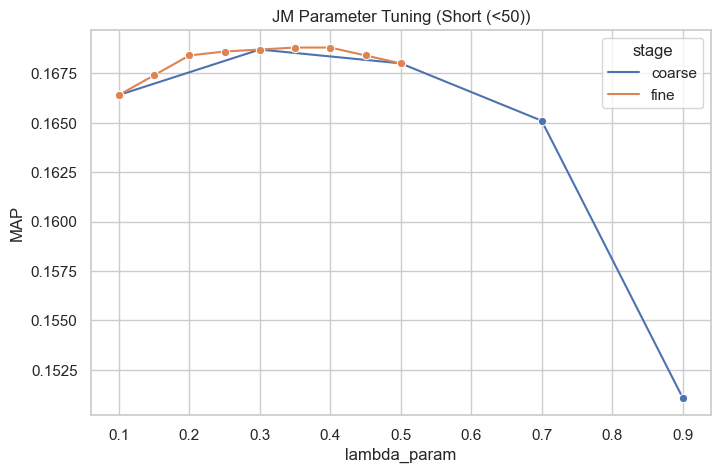


--- JM tuning for group: Medium (50–150) ---

*** TUNING PARAMETER: lambda_param for MODEL: jelinek_mercer_score ***

--- COARSE SEARCH (5 values) ---
  Testing lambda_param = 0.1 ...
     -> MAP = 0.05050
  Testing lambda_param = 0.3 ...
     -> MAP = 0.05190
  Testing lambda_param = 0.5 ...
     -> MAP = 0.05330
  Testing lambda_param = 0.7 ...
     -> MAP = 0.05510
  Testing lambda_param = 0.9 ...
     -> MAP = 0.05660
Finished coarse search.

*** Best coarse lambda_param = 0.9 with MAP = 0.05660 ***

Fine search range: 0.7000 → 1.1000 (step = 0.05)
Total fine values: 10

--- FINE SEARCH (10 values) ---
  Testing lambda_param = 0.7 ...
     -> MAP = 0.05510
  Testing lambda_param = 0.75 ...
     -> MAP = 0.05530
  Testing lambda_param = 0.8 ...
     -> MAP = 0.05580
  Testing lambda_param = 0.85 ...
     -> MAP = 0.05650
  Testing lambda_param = 0.9 ...
     -> MAP = 0.05660
  Testing lambda_param = 0.95 ...
     -> MAP = 0.05650
  Testing lambda_param = 1.0 ...
     -> MAP = 0.002

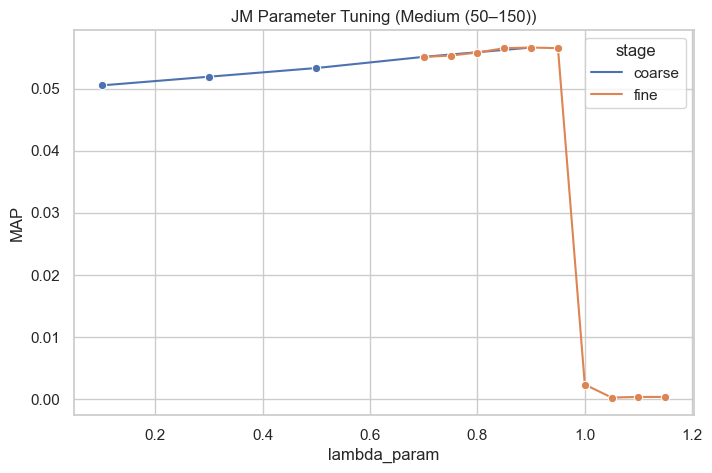


--- JM tuning for group: Long (>150) ---

*** TUNING PARAMETER: lambda_param for MODEL: jelinek_mercer_score ***

--- COARSE SEARCH (5 values) ---
  Testing lambda_param = 0.1 ...
     -> MAP = 0.00910
  Testing lambda_param = 0.3 ...
     -> MAP = 0.00940
  Testing lambda_param = 0.5 ...
     -> MAP = 0.00940
  Testing lambda_param = 0.7 ...
     -> MAP = 0.00960
  Testing lambda_param = 0.9 ...
     -> MAP = 0.01030
Finished coarse search.

*** Best coarse lambda_param = 0.9 with MAP = 0.01030 ***

Fine search range: 0.7000 → 1.1000 (step = 0.05)
Total fine values: 10

--- FINE SEARCH (10 values) ---
  Testing lambda_param = 0.7 ...
     -> MAP = 0.00960
  Testing lambda_param = 0.75 ...
     -> MAP = 0.00960
  Testing lambda_param = 0.8 ...
     -> MAP = 0.00960
  Testing lambda_param = 0.85 ...
     -> MAP = 0.00990
  Testing lambda_param = 0.9 ...
     -> MAP = 0.01030
  Testing lambda_param = 0.95 ...
     -> MAP = 0.01030
  Testing lambda_param = 1.0 ...
     -> MAP = 0.00060
 

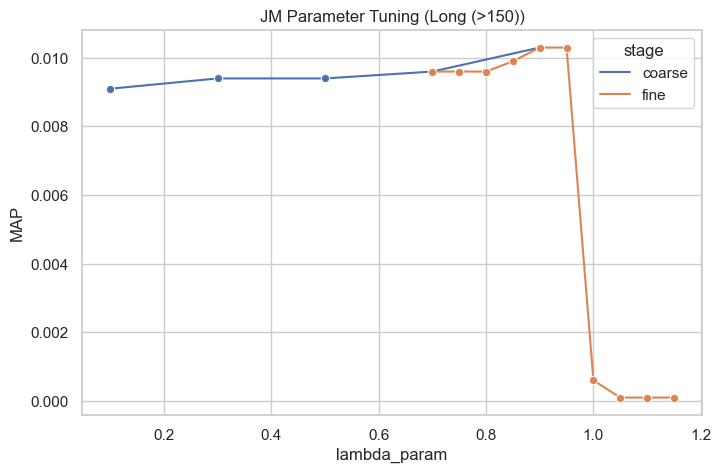


Final JM parameters per group:


{'Short (<50)': 0.35, 'Medium (50–150)': 0.9, 'Long (>150)': 0.9}

In [10]:
best_params_JM = {}

print("\n==============================")
print("TUNING JELINEK-MERCER (λ)")
print("==============================")

for group_name, group_ids in groups.items():
    print("\n--- JM tuning for group:", group_name, "---")

    best_lambda, jm_results = tune_parameter(
        group_doc_ids=group_ids,
        scoring_function=rm.jelinek_mercer_score,
        param_name="lambda_param",
        coarse_values=jm_coarse_grid,
        fine_step=0.05,
        fine_span=0.2,
    )

    best_params_JM[group_name] = best_lambda
    print(f"Best λ for {group_name}: {best_lambda}")

    plot_param_curve(jm_results, f"JM Parameter Tuning ({group_name})", "lambda_param")

print("\nFinal JM parameters per group:")
best_params_JM


TUNING DIRICHLET PRIOR (μ)

--- Dirichlet tuning for group: Short (<50) ---

*** TUNING PARAMETER: mu for MODEL: dirichlet_prior_score ***

--- COARSE SEARCH (5 values) ---
  Testing mu = 500 ...
     -> MAP = 0.18390
  Testing mu = 1000 ...
     -> MAP = 0.17440
  Testing mu = 2000 ...
     -> MAP = 0.16340
  Testing mu = 3000 ...
     -> MAP = 0.15620
  Testing mu = 4000 ...
     -> MAP = 0.14960
Finished coarse search.

*** Best coarse mu = 500 with MAP = 0.18390 ***

Fine search range: 0.0000 → 1000.0000 (step = 100)
Total fine values: 11

--- FINE SEARCH (11 values) ---
  Testing mu = 0 ...
     -> MAP = 0.05780
  Testing mu = 100 ...
     -> MAP = 0.19520
  Testing mu = 200 ...
     -> MAP = 0.19250
  Testing mu = 300 ...
     -> MAP = 0.18950
  Testing mu = 400 ...
     -> MAP = 0.18750
  Testing mu = 500 ...
     -> MAP = 0.18390
  Testing mu = 600 ...
     -> MAP = 0.17990
  Testing mu = 700 ...
     -> MAP = 0.17800
  Testing mu = 800 ...
     -> MAP = 0.17690
  Testing mu =

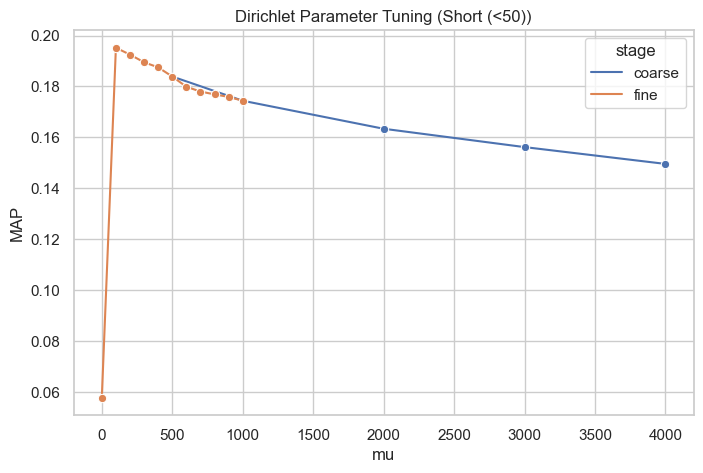


--- Dirichlet tuning for group: Medium (50–150) ---

*** TUNING PARAMETER: mu for MODEL: dirichlet_prior_score ***

--- COARSE SEARCH (5 values) ---
  Testing mu = 500 ...
     -> MAP = 0.05360
  Testing mu = 1000 ...
     -> MAP = 0.05210
  Testing mu = 2000 ...
     -> MAP = 0.05070
  Testing mu = 3000 ...
     -> MAP = 0.05000
  Testing mu = 4000 ...
     -> MAP = 0.04960
Finished coarse search.

*** Best coarse mu = 500 with MAP = 0.05360 ***

Fine search range: 0.0000 → 1000.0000 (step = 100)
Total fine values: 11

--- FINE SEARCH (11 values) ---
  Testing mu = 0 ...
     -> MAP = 0.04630
  Testing mu = 100 ...
     -> MAP = 0.05440
  Testing mu = 200 ...
     -> MAP = 0.05470
  Testing mu = 300 ...
     -> MAP = 0.05440
  Testing mu = 400 ...
     -> MAP = 0.05430
  Testing mu = 500 ...
     -> MAP = 0.05360
  Testing mu = 600 ...
     -> MAP = 0.05340
  Testing mu = 700 ...
     -> MAP = 0.05270
  Testing mu = 800 ...
     -> MAP = 0.05270
  Testing mu = 900 ...
     -> MAP = 0

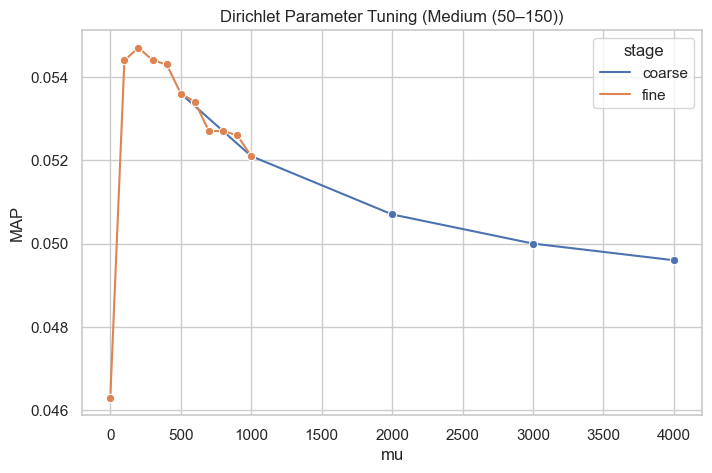


--- Dirichlet tuning for group: Long (>150) ---

*** TUNING PARAMETER: mu for MODEL: dirichlet_prior_score ***

--- COARSE SEARCH (5 values) ---
  Testing mu = 500 ...
     -> MAP = 0.00950
  Testing mu = 1000 ...
     -> MAP = 0.00910
  Testing mu = 2000 ...
     -> MAP = 0.00920
  Testing mu = 3000 ...
     -> MAP = 0.00920
  Testing mu = 4000 ...
     -> MAP = 0.00900
Finished coarse search.

*** Best coarse mu = 500 with MAP = 0.00950 ***

Fine search range: 0.0000 → 1000.0000 (step = 100)
Total fine values: 11

--- FINE SEARCH (11 values) ---
  Testing mu = 0 ...
     -> MAP = 0.00800
  Testing mu = 100 ...
     -> MAP = 0.00930
  Testing mu = 200 ...
     -> MAP = 0.00930
  Testing mu = 300 ...
     -> MAP = 0.00910
  Testing mu = 400 ...
     -> MAP = 0.00930
  Testing mu = 500 ...
     -> MAP = 0.00950
  Testing mu = 600 ...
     -> MAP = 0.00940
  Testing mu = 700 ...
     -> MAP = 0.00920
  Testing mu = 800 ...
     -> MAP = 0.00920
  Testing mu = 900 ...
     -> MAP = 0.009

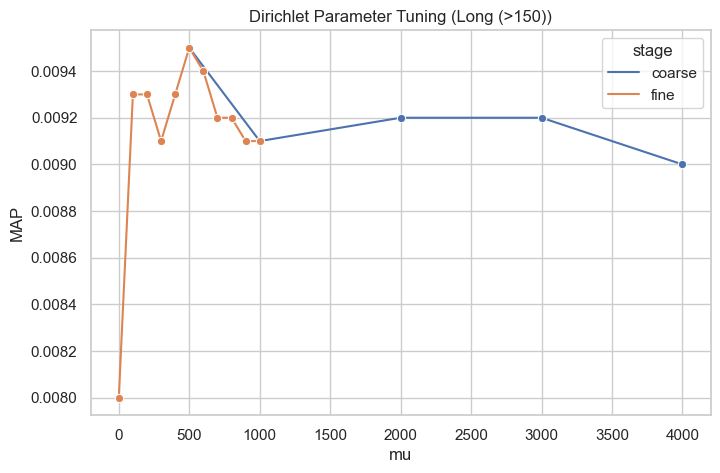


Final Dirichlet parameters per group:


{'Short (<50)': 100, 'Medium (50–150)': 200, 'Long (>150)': 500}

In [11]:
best_params_DIR = {}

print("\n==============================")
print("TUNING DIRICHLET PRIOR (μ)")
print("==============================")

for group_name, group_ids in groups.items():
    print("\n--- Dirichlet tuning for group:", group_name, "---")

    best_mu, dir_results = tune_parameter(
        group_doc_ids=group_ids,
        scoring_function=rm.dirichlet_prior_score,
        param_name="mu",
        coarse_values=dirichlet_coarse_grid,
        fine_step=100,
        fine_span=500,
    )

    best_params_DIR[group_name] = best_mu
    print(f"Best μ for {group_name}: {best_mu}")

    plot_param_curve(dir_results, f"Dirichlet Parameter Tuning ({group_name})", "mu")

print("\nFinal Dirichlet parameters per group:")
best_params_DIR


TUNING ABSOLUTE DISCOUNTING (δ)

--- AD tuning for group: Short (<50) ---

*** TUNING PARAMETER: delta for MODEL: absolute_discounting_score ***

--- COARSE SEARCH (5 values) ---
  Testing delta = 0.1 ...
     -> MAP = 0.16450
  Testing delta = 0.3 ...
     -> MAP = 0.16980
  Testing delta = 0.5 ...
     -> MAP = 0.17310
  Testing delta = 0.7 ...
     -> MAP = 0.17830
  Testing delta = 0.9 ...
     -> MAP = 0.17640
Finished coarse search.

*** Best coarse delta = 0.7 with MAP = 0.17830 ***

Fine search range: 0.5000 → 0.9000 (step = 0.05)
Total fine values: 9

--- FINE SEARCH (9 values) ---
  Testing delta = 0.5 ...
     -> MAP = 0.17310
  Testing delta = 0.55 ...
     -> MAP = 0.17470
  Testing delta = 0.6 ...
     -> MAP = 0.17520
  Testing delta = 0.65 ...
     -> MAP = 0.17670
  Testing delta = 0.7 ...
     -> MAP = 0.17830
  Testing delta = 0.75 ...
     -> MAP = 0.17970
  Testing delta = 0.8 ...
     -> MAP = 0.18200
  Testing delta = 0.85 ...
     -> MAP = 0.18130
  Testing del

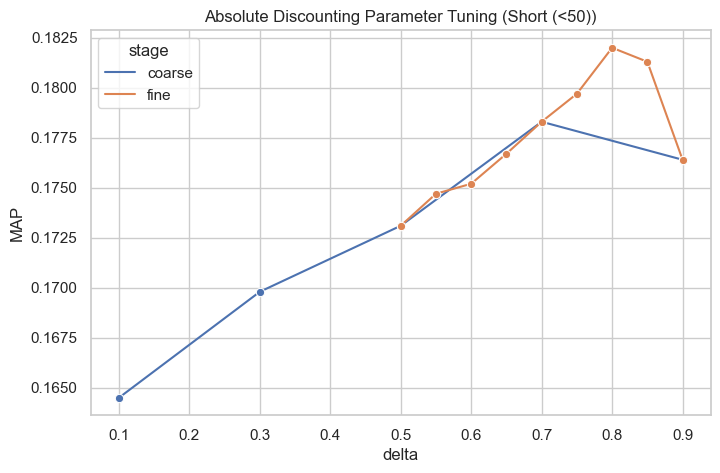


--- AD tuning for group: Medium (50–150) ---

*** TUNING PARAMETER: delta for MODEL: absolute_discounting_score ***

--- COARSE SEARCH (5 values) ---
  Testing delta = 0.1 ...
     -> MAP = 0.05010
  Testing delta = 0.3 ...
     -> MAP = 0.05170
  Testing delta = 0.5 ...
     -> MAP = 0.05410
  Testing delta = 0.7 ...
     -> MAP = 0.05610
  Testing delta = 0.9 ...
     -> MAP = 0.05690
Finished coarse search.

*** Best coarse delta = 0.9 with MAP = 0.05690 ***

Fine search range: 0.7000 → 1.1000 (step = 0.05)
Total fine values: 10

--- FINE SEARCH (10 values) ---
  Testing delta = 0.7 ...
     -> MAP = 0.05610
  Testing delta = 0.75 ...
     -> MAP = 0.05670
  Testing delta = 0.8 ...
     -> MAP = 0.05730
  Testing delta = 0.85 ...
     -> MAP = 0.05730
  Testing delta = 0.9 ...
     -> MAP = 0.05690
  Testing delta = 0.95 ...
     -> MAP = 0.05560
  Testing delta = 1.0 ...
     -> MAP = 0.04810
  Testing delta = 1.05 ...
     -> MAP = 0.04820
  Testing delta = 1.1 ...
     -> MAP = 

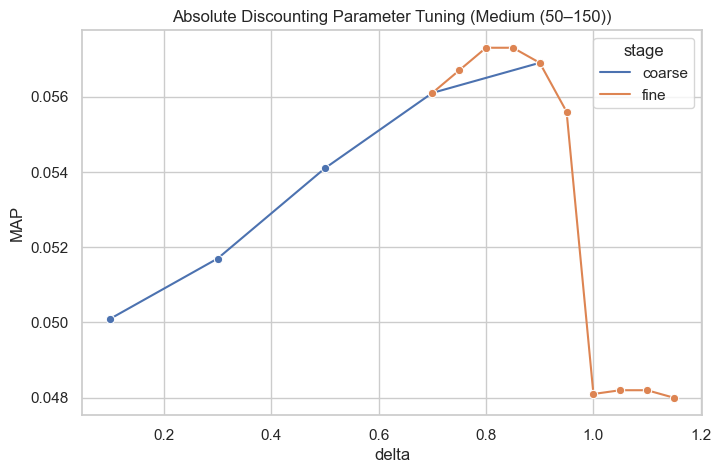


--- AD tuning for group: Long (>150) ---

*** TUNING PARAMETER: delta for MODEL: absolute_discounting_score ***

--- COARSE SEARCH (5 values) ---
  Testing delta = 0.1 ...
     -> MAP = 0.00870
  Testing delta = 0.3 ...
     -> MAP = 0.00930
  Testing delta = 0.5 ...
     -> MAP = 0.00940
  Testing delta = 0.7 ...
     -> MAP = 0.00940
  Testing delta = 0.9 ...
     -> MAP = 0.00960
Finished coarse search.

*** Best coarse delta = 0.9 with MAP = 0.00960 ***

Fine search range: 0.7000 → 1.1000 (step = 0.05)
Total fine values: 10

--- FINE SEARCH (10 values) ---
  Testing delta = 0.7 ...
     -> MAP = 0.00940
  Testing delta = 0.75 ...
     -> MAP = 0.00940
  Testing delta = 0.8 ...
     -> MAP = 0.00940
  Testing delta = 0.85 ...
     -> MAP = 0.00940
  Testing delta = 0.9 ...
     -> MAP = 0.00960
  Testing delta = 0.95 ...
     -> MAP = 0.00970
  Testing delta = 1.0 ...
     -> MAP = 0.00910
  Testing delta = 1.05 ...
     -> MAP = 0.00910
  Testing delta = 1.1 ...
     -> MAP = 0.00

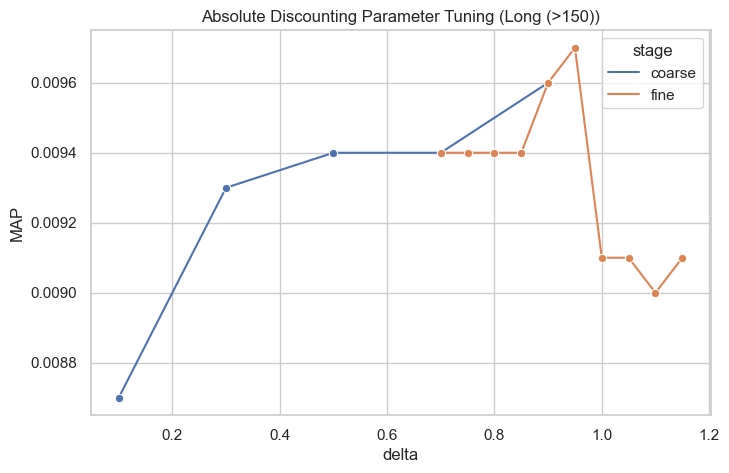


Final AD parameters per group:


{'Short (<50)': 0.8, 'Medium (50–150)': 0.8, 'Long (>150)': 0.95}

In [19]:
best_params_AD = {}

print("\n==============================")
print("TUNING ABSOLUTE DISCOUNTING (δ)")
print("==============================")

for group_name, group_ids in groups.items():
    print("\n--- AD tuning for group:", group_name, "---")

    best_delta, ad_results = tune_parameter(
        group_doc_ids=group_ids,
        scoring_function=rm.absolute_discounting_score,
        param_name="delta",
        coarse_values=ad_coarse_grid,
        fine_step=0.05,
        fine_span=0.2,
    )

    best_params_AD[group_name] = best_delta
    print(f"Best δ for {group_name}: {best_delta}")

    plot_param_curve(
        ad_results, f"Absolute Discounting Parameter Tuning ({group_name})", "delta"
    )

print("\nFinal AD parameters per group:")
best_params_AD

## Q1 - Part (ج)

In [20]:
groups["All"] = set(doc_id_to_len.keys())


TUNING JELINEK-MERCER (ALL DOCUMENTS)

*** TUNING PARAMETER: lambda_param for MODEL: jelinek_mercer_score ***

--- COARSE SEARCH (5 values) ---
  Testing lambda_param = 0.1 ...
     -> MAP = 0.19580
  Testing lambda_param = 0.3 ...
     -> MAP = 0.20160
  Testing lambda_param = 0.5 ...
     -> MAP = 0.20210
  Testing lambda_param = 0.7 ...
     -> MAP = 0.19780
  Testing lambda_param = 0.9 ...
     -> MAP = 0.17820
Finished coarse search.

*** Best coarse lambda_param = 0.5 with MAP = 0.20210 ***

Fine search range: 0.3000 → 0.7000 (step = 0.05)
Total fine values: 9

--- FINE SEARCH (9 values) ---
  Testing lambda_param = 0.3 ...
     -> MAP = 0.20160
  Testing lambda_param = 0.35 ...
     -> MAP = 0.20220
  Testing lambda_param = 0.4 ...
     -> MAP = 0.20240
  Testing lambda_param = 0.45 ...
     -> MAP = 0.20250
  Testing lambda_param = 0.5 ...
     -> MAP = 0.20210
  Testing lambda_param = 0.55 ...
     -> MAP = 0.20180
  Testing lambda_param = 0.6 ...
     -> MAP = 0.20050
  Test

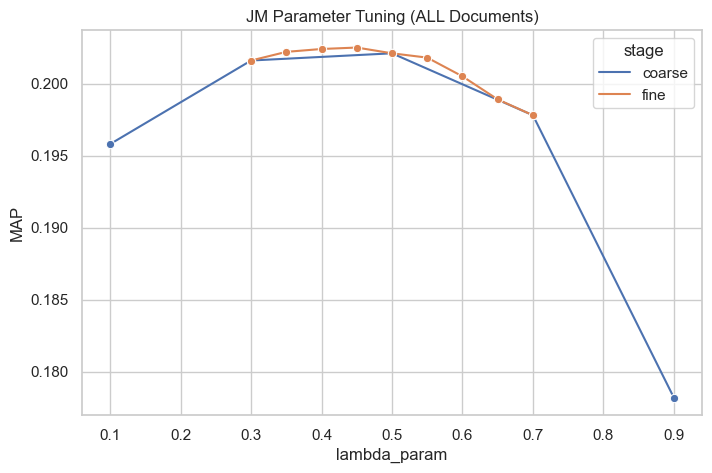

In [21]:
print("\n==============================")
print("TUNING JELINEK-MERCER (ALL DOCUMENTS)")
print("==============================")

best_lambda_all, jm_all_results = tune_parameter(
    group_doc_ids=groups["All"],
    scoring_function=rm.jelinek_mercer_score,
    param_name="lambda_param",
    coarse_values=jm_coarse_grid,
    fine_step=0.05,
    fine_span=0.2,
)

print(f"\nBest λ for ALL documents = {best_lambda_all}")

plot_param_curve(jm_all_results, "JM Parameter Tuning (ALL Documents)", "lambda_param")
best_params_JM["All"] = best_lambda_all


TUNING DIRICHLET PRIOR (ALL DOCUMENTS)

*** TUNING PARAMETER: mu for MODEL: dirichlet_prior_score ***

--- COARSE SEARCH (5 values) ---
  Testing mu = 500 ...
     -> MAP = 0.20450
  Testing mu = 1000 ...
     -> MAP = 0.18510
  Testing mu = 2000 ...
     -> MAP = 0.16730
  Testing mu = 3000 ...
     -> MAP = 0.15760
  Testing mu = 4000 ...
     -> MAP = 0.15170
Finished coarse search.

*** Best coarse mu = 500 with MAP = 0.20450 ***

Fine search range: 0.0000 → 1000.0000 (step = 100)
Total fine values: 11

--- FINE SEARCH (11 values) ---
  Testing mu = 0 ...
     -> MAP = 0.06850
  Testing mu = 100 ...
     -> MAP = 0.23430
  Testing mu = 200 ...
     -> MAP = 0.22740
  Testing mu = 300 ...
     -> MAP = 0.21920
  Testing mu = 400 ...
     -> MAP = 0.21170
  Testing mu = 500 ...
     -> MAP = 0.20450
  Testing mu = 600 ...
     -> MAP = 0.19970
  Testing mu = 700 ...
     -> MAP = 0.19500
  Testing mu = 800 ...
     -> MAP = 0.19210
  Testing mu = 900 ...
     -> MAP = 0.18870
  Test

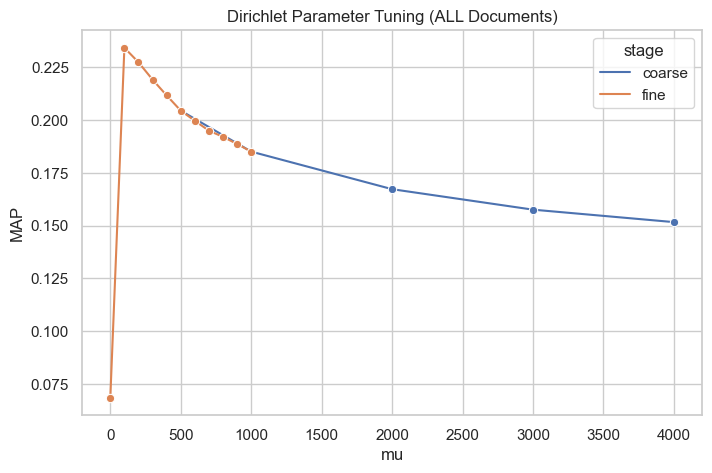

In [22]:
print("\n==============================")
print("TUNING DIRICHLET PRIOR (ALL DOCUMENTS)")
print("==============================")

best_mu_all, dir_all_results = tune_parameter(
    group_doc_ids=groups["All"],
    scoring_function=rm.dirichlet_prior_score,
    param_name="mu",
    coarse_values=dirichlet_coarse_grid,
    fine_step=100,
    fine_span=500,
)

print(f"\nBest μ for ALL documents = {best_mu_all}")

plot_param_curve(dir_all_results, "Dirichlet Parameter Tuning (ALL Documents)", "mu")
best_params_DIR["All"] = best_mu_all


TUNING ABSOLUTE DISCOUNTING (ALL DOCUMENTS)

*** TUNING PARAMETER: delta for MODEL: absolute_discounting_score ***

--- COARSE SEARCH (5 values) ---
  Testing delta = 0.1 ...
     -> MAP = 0.19390
  Testing delta = 0.3 ...
     -> MAP = 0.20310
  Testing delta = 0.5 ...
     -> MAP = 0.20980
  Testing delta = 0.7 ...
     -> MAP = 0.21770
  Testing delta = 0.9 ...
     -> MAP = 0.21800
Finished coarse search.

*** Best coarse delta = 0.9 with MAP = 0.21800 ***

Fine search range: 0.7000 → 1.1000 (step = 0.05)
Total fine values: 10

--- FINE SEARCH (10 values) ---
  Testing delta = 0.7 ...
     -> MAP = 0.21770
  Testing delta = 0.75 ...
     -> MAP = 0.21940
  Testing delta = 0.8 ...
     -> MAP = 0.22180
  Testing delta = 0.85 ...
     -> MAP = 0.22180
  Testing delta = 0.9 ...
     -> MAP = 0.21800
  Testing delta = 0.95 ...
     -> MAP = 0.20180
  Testing delta = 1.0 ...
     -> MAP = 0.12000
  Testing delta = 1.05 ...
     -> MAP = 0.12020
  Testing delta = 1.1 ...
     -> MAP = 0

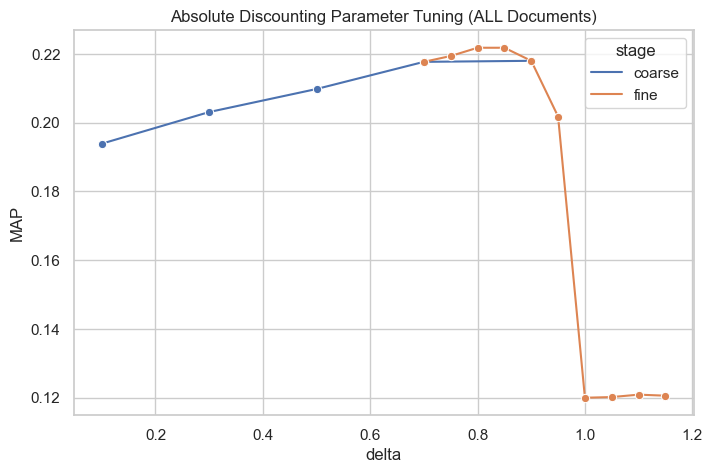

In [23]:
print("\n==============================")
print("TUNING ABSOLUTE DISCOUNTING (ALL DOCUMENTS)")
print("==============================")

best_delta_all, ad_all_results = tune_parameter(
    group_doc_ids=groups["All"],
    scoring_function=rm.absolute_discounting_score,
    param_name="delta",
    coarse_values=ad_coarse_grid,
    fine_step=0.05,
    fine_span=0.2,
)

print(f"\nBest δ for ALL documents = {best_delta_all}")

plot_param_curve(
    ad_all_results, "Absolute Discounting Parameter Tuning (ALL Documents)", "delta"
)
best_params_AD["All"] = best_delta_all

### **Best params of each method per group**

In [24]:
best_params_per_group = {}

for group_name in groups.keys():
    best_params_per_group[group_name] = {
        "lambda": best_params_JM[group_name],
        "mu": best_params_DIR[group_name],
        "delta": best_params_AD[group_name],
    }

print("\n==============================")
print("FINAL OPTIMIZED PARAMETERS PER GROUP")
print("==============================")
best_params_per_group


FINAL OPTIMIZED PARAMETERS PER GROUP


{'Short (<50)': {'lambda': 0.35, 'mu': 100, 'delta': 0.8},
 'Medium (50–150)': {'lambda': 0.9, 'mu': 200, 'delta': 0.8},
 'Long (>150)': {'lambda': 0.9, 'mu': 500, 'delta': 0.95},
 'All': {'lambda': 0.45, 'mu': 100, 'delta': 0.8}}

### **Final Evaluation of All 3 Smoothing Models Using Optimized Parameters per Group**

In [26]:
results_records = []

for group_name, doc_ids in groups.items():

    params = best_params_per_group[group_name]

    smoothing_methods = [
        (rm.jelinek_mercer_score, {"lambda_param": params["lambda"]}),
        (rm.dirichlet_prior_score, {"mu": params["mu"]}),
        (rm.absolute_discounting_score, {"delta": params["delta"]}),
    ]

    for func, fixed in smoothing_methods:
        scorer = make_group_scoring(func, allowed_doc_ids=doc_ids, fixed_params=fixed)

        metrics = ev.evaluate_scoring_method(
            inverted_index=inverted_index,
            scoring_method=scorer,
            queries=queries,
            relevance_judgments=relevance_judgments,
            params={},
            min_relevant=3,
        )

        results_records.append(
            {
                "Group": group_name,
                "Model": func.__name__,
                "Parameters": fixed,
                "MAP": metrics["MAP"],
                "Precision@3": metrics["Precision@3"],
                "Precision@10": metrics["Precision@10"],
                "Recall@10": metrics["Recall@10"],
                "nDCG@10": metrics["nDCG@10"],
            }
        )

results_df = pd.DataFrame(results_records)
display(results_df)

,Group,Model,Parameters,MAP,Precision@3,Precision@10,Recall@10,nDCG@10
0,Short (<50),jelinek_mercer_score,{'lambda_param': 0.35},0.1688,0.3067,0.2155,0.1887,0.3663
1,Short (<50),dirichlet_prior_score,{'mu': 100},0.1952,0.3683,0.2555,0.2093,0.4023
2,Short (<50),absolute_discounting_score,{'delta': 0.8},0.1820,0.3333,0.2385,0.2008,0.3994
3,Medium (50–150),jelinek_mercer_score,{'lambda_param': 0.9},0.0566,0.2367,0.1115,0.0794,0.1831
4,Medium (50–150),dirichlet_prior_score,{'mu': 200},0.0547,0.2167,0.1080,0.0771,0.1777
5,Medium (50–150),absolute_discounting_score,{'delta': 0.8},0.0573,0.2400,0.1095,0.0791,0.1817
6,Long (>150),jelinek_mercer_score,{'lambda_param': 0.9},0.0103,0.0517,0.0180,0.0116,0.0334
7,Long (>150),dirichlet_prior_score,{'mu': 500},0.0095,0.0483,0.0180,0.0116,0.0317
8,Long (>150),absolute_discounting_score,{'delta': 0.95},0.0097,0.0500,0.0180,0.0116,0.0318
9,All,jelinek_mercer_score,{'lambda_param': 0.45},0.2025,0.3233,0.2355,0.2057,0.3849


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
 
بهترین مدل روی `اسناد کوتاه` Dirichlet Prior است

در اسناد کوتاه، تعداد واژه‌های سند خیلی کم -میانگین 14 واژه- است، بنابراین احتمال‌های Maximum Likelihood تقریباً کل توزیع را صفر می‌کنند. Dirichlet از بین سه روش بیشتر کمک می‌کند. احتمالا به این خاطر که هر چی سند کوتاه تر میشود در روش Dir درصد بیشتری از احتمال به مدل زبانی مرجع داده می شود. این بخاطر رفتار داینامیک ضرایب مدل زبانی سند و مدل زبانی مرجع در فرمول Dir نسبت به طول اسناد است.

در `اسناد با طول متوسط` وضعیت متفاوت است و روش Dirichlet Prior بدترین روش و دو روش JM و AD تقریبا نزدیک به هم و بهتر هستند.

در `اسناد بلند` عملکرد هر سه روش بد است. ولی عملکرد JM از AD بهتر و Dir در اینجا هم عملکرد بدتری نسبت به دو روش دیگر دارد.

کل اسناد :

| مدل               | MAP        |
| ----------------- | ---------- |
| JM (λ=0.45)       | 0.2025     |
| Dirichlet (μ=100) | **0.2343** |
| AD (δ=0.8)        | 0.2218     |

این نتیجه هم کاملاً منطقی است چون ۹۳ درصد اسناد کوتاه‌اند و Dirichlet در اسناد کوتاه بهترین بود.


**بنابر مقایسه MAP**

- اسناد کوتاه: بهترین روش Dirichlet

- اسناد متوسط: بهترین روش Absolute Discounting

- اسناد بلند: بهترین روش Jelinek–Mercer

**سوال 2: در کدام گروه رو شهای هموارسازی عملکرد بهتری دارند؟**

|            گروه                | بیشترین MAP      |
| -----------------   | ---------- |
| اسناد کوتاه       |   **0.1952**  |
| اسناد متوسط | 0.0573 |
| اسناد بلند       | 0.0103	     |

در اسناد کوتاه مدل های هموارسازی عملکرد بهتری داشته اند.



**سؤال 3: رابطه طول سند و شدت تأثیر هموارسازی چیست؟**

بنابر نتایج بدست آمده هرچه طول سند کمتر باشد، روش های هموارسازی اثر قوی تری داشته و بهتر عمل می کنند.
چون در سند کوتاه چون احتمال خیلی از واژه های جست و جو در مدل زبانی سند صفر می شود برای جلوگیری از این موضوع نیاز داریم که با هموارسازی از احتمال مدل زبانی مرجع استفاده کنیم.
اما هرچه طول سند بیشتر می شود، مدل سند قوی است و سطح خیلی کمی از هموارسازی نیاز است.


# **Question 2**

## Q2 - Part (الف)

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
شناسایی واژه های نادر

In [27]:
N = inverted_index.doc_count
threshold = 0.01 * N

rare_terms = {
    term for term, df in inverted_index.term_doc_freq.items() if df < threshold
}

print(f"Total documents: {N}")
print(f"Rare term threshold (df < 1%): {threshold:.0f}")
print(f"Number of rare terms: {len(rare_terms)}")

Total documents: 403666
Rare term threshold (df < 1%): 4037
Number of rare terms: 125311


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
گروه بندی پرس و جو ها بر اساس تعداد واژه های کمیاب

In [28]:
query_groups = {"none": [], "low": [], "high": []}

query_rare_count = {}

for q in queries:
    rare_count = sum(1 for t in q.tokens if t in rare_terms)
    query_rare_count[q.query_id] = rare_count

    if rare_count == 0:
        query_groups["none"].append(q)
    elif rare_count <= 2:
        query_groups["low"].append(q)
    else:
        query_groups["high"].append(q)

In [29]:
print("\n===== Query Rare-Term Statistics =====")
print(f"Rare terms total: {len(rare_terms)}\n")

for group_name, qs in query_groups.items():
    print(f"Group '{group_name}':")
    print(f"  Number of queries: {len(qs)}")

    if len(qs) > 0:
        avg_rare = sum(query_rare_count[q.query_id] for q in qs) / len(qs)
        print(f"  Average number of rare terms: {avg_rare:.2f}")

    print("-" * 40)


===== Query Rare-Term Statistics =====
Rare terms total: 125311

Group 'none':
  Number of queries: 8
  Average number of rare terms: 0.00
----------------------------------------
Group 'low':
  Number of queries: 86
  Average number of rare terms: 1.65
----------------------------------------
Group 'high':
  Number of queries: 106
  Average number of rare terms: 4.08
----------------------------------------


## Q2 - Part (ب)

In [30]:
params_all = best_params_per_group["All"]

lambda_all = params_all["lambda"]
mu_all = params_all["mu"]
delta_all = params_all["delta"]

print("Using optimal ALL parameters:")
print(params_all)

Using optimal ALL parameters:
{'lambda': 0.45, 'mu': 100, 'delta': 0.8}


In [31]:
smoothing_methods = [
    ("JM", rm.jelinek_mercer_score, {"lambda_param": lambda_all}),
    ("Dirichlet", rm.dirichlet_prior_score, {"mu": mu_all}),
    ("AD", rm.absolute_discounting_score, {"delta": delta_all}),
]

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
اجرای مدل های هموارسازی بر روی گروه های مختلف پرس و جو با استفاده از پارامتر های بهینه سوال قبل
     
و مقایسه عملکرد روش ها در گروه های مختلف جست و جو با یکدیگر

In [32]:
results_q2b = []

print("\n========== Q2-b Evaluation on Rare-Term Query Groups ==========\n")

for group_name, group_queries in query_groups.items():

    print(f"\n--- Evaluating group: {group_name} ---")
    print(f"Number of queries in this group: {len(group_queries)}")

    if len(group_queries) == 0:
        print("Skipping empty group.")
        continue

    for model_name, func, fixed_params in smoothing_methods:
        print(f"  Running model {model_name} with params = {fixed_params}")

        scorer = make_group_scoring(
            scoring_func=func,
            allowed_doc_ids=groups["All"],
            fixed_params=fixed_params,
        )

        metrics = ev.evaluate_scoring_method(
            inverted_index=inverted_index,
            scoring_method=scorer,
            queries=group_queries,
            relevance_judgments=relevance_judgments,
            params={},
            min_relevant=3,
        )

        results_q2b.append(
            {
                "Group": group_name,
                "Model": model_name,
                "Parameters": fixed_params,
                "MAP": metrics["MAP"],
                "MRR": metrics["MRR"],
                "Precision@3": metrics["Precision@3"],
                "Precision@10": metrics["Precision@10"],
                "Recall@3": metrics["Recall@3"],
                "Recall@10": metrics["Recall@10"],
                "nDCG@10": metrics["nDCG@10"],
            }
        )

results_q2b_df = pd.DataFrame(results_q2b)
display(results_q2b_df)


========== Q2-b Evaluation on Rare-Term Query Groups ==========


--- Evaluating group: none ---
Number of queries in this group: 8
  Running model JM with params = {'lambda_param': 0.45}
  Running model Dirichlet with params = {'mu': 100}
  Running model AD with params = {'delta': 0.8}

--- Evaluating group: low ---
Number of queries in this group: 86
  Running model JM with params = {'lambda_param': 0.45}
  Running model Dirichlet with params = {'mu': 100}
  Running model AD with params = {'delta': 0.8}

--- Evaluating group: high ---
Number of queries in this group: 106
  Running model JM with params = {'lambda_param': 0.45}
  Running model Dirichlet with params = {'mu': 100}
  Running model AD with params = {'delta': 0.8}


,Group,Model,Parameters,MAP,MRR,Precision@3,Precision@10,Recall@3,Recall@10,nDCG@10
0,none,JM,{'lambda_param': 0.45},0.0318,0.1374,0.0833,0.0375,0.0109,0.0163,0.0763
1,none,Dirichlet,{'mu': 100},0.0535,0.1882,0.1667,0.1000,0.0265,0.0506,0.1246
2,none,AD,{'delta': 0.8},0.0411,0.1594,0.0833,0.0875,0.0109,0.0452,0.1114
3,low,JM,{'lambda_param': 0.45},0.1635,0.4363,0.2752,0.1919,0.0794,0.1645,0.3426
4,low,Dirichlet,{'mu': 100},0.2063,0.5866,0.3760,0.2581,0.0920,0.1961,0.3966
5,low,AD,{'delta': 0.8},0.1876,0.5207,0.3256,0.2407,0.0861,0.1882,0.3956
6,high,JM,{'lambda_param': 0.45},0.2470,0.5942,0.3805,0.2858,0.1160,0.2535,0.4426
7,high,Dirichlet,{'mu': 100},0.2706,0.6143,0.4465,0.3038,0.1303,0.2621,0.4501
8,high,AD,{'delta': 0.8},0.2632,0.6114,0.4214,0.3047,0.1188,0.2619,0.4718


## Q2 - Part (ج)

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
 اجرای Mixture Model PRF روی سه گروه پرس و جو

In [34]:
results_mixture = []

params_all = best_params_per_group["All"]

lambda_all = params_all["lambda"]
mu_all = params_all["mu"]
delta_all = params_all["delta"]

print("\n======================")
print("RUNNING: Mixture Model PRF")
print("======================")

for group_name, group_queries in query_groups.items():
    print(f"\n--- Group: {group_name} ---")
    print(f"Number of queries: {len(group_queries)}")

    if len(group_queries) == 0:
        continue

    expanded_queries = []

    for q in group_queries:
        new_q = qp.Query(q.query_id, q.text)
        new_q.tokens = list(q.tokens)
        new_q.term_weights = dict(q.term_weights)

        rm.mixture_model_prf(new_q, inverted_index, top_n=10, num_expansion_terms=10)

        expanded_queries.append(new_q)

    smoothing_methods = [
        ("JM", rm.jelinek_mercer_score, {"lambda_param": lambda_all}),
        ("DIR", rm.dirichlet_prior_score, {"mu": mu_all}),
        ("AD", rm.absolute_discounting_score, {"delta": delta_all}),
    ]

    for model_name, func, fixed in smoothing_methods:
        scorer = make_group_scoring(
            scoring_func=func, allowed_doc_ids=groups["All"], fixed_params=fixed
        )

        metrics = ev.evaluate_scoring_method(
            inverted_index=inverted_index,
            scoring_method=scorer,
            queries=expanded_queries,
            relevance_judgments=relevance_judgments,
            params={},
            min_relevant=3,
        )

        results_mixture.append(
            {
                "PRF": "Mixture",
                "Group": group_name,
                "Model": model_name,
                "Params": fixed,
                "MAP": metrics["MAP"],
                "MRR": metrics["MRR"],
                "P@10": metrics["Precision@10"],
                "nDCG@10": metrics["nDCG@10"],
            }
        )

results_mixture_df = pd.DataFrame(results_mixture)
display(results_mixture_df)


RUNNING: Mixture Model PRF

--- Group: none ---
Number of queries: 8


EM Iterations:  12%|█▏        | 6/50 [00:00<00:00, 578.84iter/s]



--- Group: low ---
Number of queries: 86


EM Iterations:   8%|▊         | 4/50 [00:00<?, ?iter/s]



--- Group: high ---
Number of queries: 106


EM Iterations:  14%|█▍        | 7/50 [00:00<?, ?iter/s]


,PRF,Group,Model,Params,MAP,MRR,P@10,nDCG@10
0,Mixture,none,JM,{'lambda_param': 0.45},0.0318,0.1437,0.0625,0.0745
1,Mixture,none,DIR,{'mu': 100},0.0249,0.1409,0.0500,0.0634
2,Mixture,none,AD,{'delta': 0.8},0.0475,0.1693,0.1125,0.1179
3,Mixture,low,JM,{'lambda_param': 0.45},0.1308,0.4878,0.1756,0.2881
4,Mixture,low,DIR,{'mu': 100},0.1311,0.4860,0.1779,0.2893
5,Mixture,low,AD,{'delta': 0.8},0.1935,0.5589,0.2523,0.3985
6,Mixture,high,JM,{'lambda_param': 0.45},0.1857,0.5598,0.2358,0.3583
7,Mixture,high,DIR,{'mu': 100},0.1898,0.5542,0.2368,0.3565
8,Mixture,high,AD,{'delta': 0.8},0.2712,0.6335,0.3066,0.4686


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
 اجرای Divergence Minimization PRF روی سه گروه پرس و جو

In [37]:
results_dm = []

params_all = best_params_per_group["All"]

lambda_all = params_all["lambda"]
mu_all = params_all["mu"]
delta_all = params_all["delta"]

print("\n======================")
print("RUNNING: DM-PRF (Divergence Minimization)")
print("======================")

for group_name, group_queries in query_groups.items():
    print(f"\n--- Group: {group_name} ---")

    if len(group_queries) == 0:
        continue

    expanded_queries = []

    for q in group_queries:
        new_q = qp.Query(q.query_id, q.text)
        new_q.tokens = list(q.tokens)
        new_q.term_weights = dict(q.term_weights)

        rm.divergence_minimization_prf(
            new_q,
            inverted_index,
            top_n=10,
            num_expansion_terms=10,
            lambda_param=0.1,
            mu=2000,
        )

        expanded_queries.append(new_q)

    smoothing_methods = [
        ("JM", rm.jelinek_mercer_score, {"lambda_param": lambda_all}),
        ("DIR", rm.dirichlet_prior_score, {"mu": mu_all}),
        ("AD", rm.absolute_discounting_score, {"delta": delta_all}),
    ]

    for model_name, func, fixed in smoothing_methods:
        scorer = make_group_scoring(
            scoring_func=func, allowed_doc_ids=groups["All"], fixed_params=fixed
        )

        metrics = ev.evaluate_scoring_method(
            scoring_method=scorer,
            inverted_index=inverted_index,
            queries=expanded_queries,
            relevance_judgments=relevance_judgments,
            params={},
        )

        results_dm.append(
            {
                "PRF": "DM-PRF",
                "Group": group_name,
                "Model": model_name,
                "Params": fixed,
                "MAP": metrics["MAP"],
                "MRR": metrics["MRR"],
                "P@10": metrics["Precision@10"],
                "nDCG@10": metrics["nDCG@10"],
            }
        )

results_dm_df = pd.DataFrame(results_dm)
display(results_dm_df)


RUNNING: DM-PRF (Divergence Minimization)

--- Group: none ---

--- Group: low ---

--- Group: high ---


,PRF,Group,Model,Params,MAP,MRR,P@10,nDCG@10
0,DM-PRF,none,JM,{'lambda_param': 0.45},0.0131,0.1272,0.0250,0.0508
1,DM-PRF,none,DIR,{'mu': 100},0.0077,0.1283,0.0125,0.0352
2,DM-PRF,none,AD,{'delta': 0.8},0.0411,0.1594,0.0875,0.1114
3,DM-PRF,low,JM,{'lambda_param': 0.45},0.1320,0.4625,0.1826,0.3016
4,DM-PRF,low,DIR,{'mu': 100},0.1280,0.4703,0.1802,0.2979
5,DM-PRF,low,AD,{'delta': 0.8},0.1636,0.4847,0.2140,0.3500
6,DM-PRF,high,JM,{'lambda_param': 0.45},0.1915,0.5702,0.2368,0.3692
7,DM-PRF,high,DIR,{'mu': 100},0.1831,0.5665,0.2330,0.3650
8,DM-PRF,high,AD,{'delta': 0.8},0.2287,0.5636,0.2642,0.4190


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">
مقایسه عملکرد قبل و بعد از گسترش پرس و جو با دو روش قسمت قبل

In [40]:
normalize = {
    "Dirichlet": "DIR",
    "DIRICHLET": "DIR",
    "dirichlet": "DIR",
}

for df in [results_q2b_df, results_mixture_df, results_dm_df]:
    df["Model"] = df["Model"].replace(normalize)

results_q2b_df["PRF"] = "None"
results_mixture_df["PRF"] = "Mixture"
results_dm_df["PRF"] = "DM"
combined_q2_df = pd.concat(
    [results_q2b_df, results_mixture_df, results_dm_df], ignore_index=True
)
comparison_df = combined_q2_df.pivot_table(
    index=["Group", "Model"], columns="PRF", values=["MAP", "nDCG@10"]
)
print("Comparison of Baseline (without expansion) vs Mixture PRF vs DM PRF")
display(comparison_df)

Comparison of Baseline (without expansion) vs Mixture PRF vs DM PRF


MAP                 nDCG@10                
PRF              DM Mixture    None      DM Mixture    None
Group Model                                                
high  AD     0.2287  0.2712  0.2632  0.4190  0.4686  0.4718
      DIR    0.1831  0.1898  0.2706  0.3650  0.3565  0.4501
      JM     0.1915  0.1857  0.2470  0.3692  0.3583  0.4426
low   AD     0.1636  0.1935  0.1876  0.3500  0.3985  0.3956
      DIR    0.1280  0.1311  0.2063  0.2979  0.2893  0.3966
      JM     0.1320  0.1308  0.1635  0.3016  0.2881  0.3426
none  AD     0.0411  0.0475  0.0411  0.1114  0.1179  0.1114
      DIR    0.0077  0.0249  0.0535  0.0352  0.0634  0.1246
      JM     0.0131  0.0318  0.0318  0.0508  0.0745  0.0763

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 18px;">

**تحلیل نتایج برای گروه پرس و جوهای None**

| مدل       | Baseline | Mixture PRF | DM-PRF | جمع‌بندی خیلی کوتاه          |
| --------- | -------- | ----------- | ------ | ----------------------------  |
| JM        | 0.0318   | 0.0318      | 0.0131 | Mixture بی اثر؛ DM اثرمنفی داشته  |
| Dirichlet | 0.0535   | 0.0249      | 0.0077 | هر دو PRF بدتر از Baseline |
| AD        | 0.0411   | 0.0475      | 0.0411 | Mixture کمی بهتر کرده؛ DM ثابت   |

**تحلیل نتایج برای گروه پرس و جوهای Low**

| مدل       | Baseline | Mixture PRF | DM-PRF | جمع‌بندی خیلی کوتاه         |
| --------- | -------- | ----------- | ------ | --------------------------- |
| JM        | 0.1635   | 0.1308      | 0.1320 | هر دو PRF بدتر از Baseline  |
| Dirichlet | 0.2063   | 0.1311      | 0.1280 | هر دو PRF بدتر از Baseline  |
| AD        | 0.1876   | 0.1935      | 0.1636 | Mixture بهتر کرده؛ DM بی اثر |


**تحلیل نتایج برای گروه پرس و جوهای High**

| مدل       | Baseline | Mixture PRF | DM-PRF | جمع‌بندی خیلی کوتاه          |
| --------- | -------- | ----------- | ------ | ---------------------------- |
| JM        | 0.2470   | 0.1857      | 0.1915 | هر دو PRF بدتر از Baseline  |
| Dirichlet | 0.2706   | 0.1898      | 0.1831 | هر دو PRF بدتر از Baseline  |
| AD        | 0.2632   | **0.2712**  | 0.2287 | Mixture بهترین نتیجه کل جدول |

درکل Mixture بعضی جاها تونسته عملکرد بهتری نسبت به گسترش ندادن پرس و جو داشته باشه اما روش DM-PRF همواره اثر منفی داشته روی نتایج

نتایج بر روی پرس و جو های گروه High بالاتر از گروه Low و آن هم بالاتر از گروه None می باشد. بنظر این نشان می دهد که هر چقدر از واژه های شاخص توی پرس و جو استفاده کنیم تاثیر بهتری می گیریم. 

# **نکات مهم**

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;">
    <p><strong>مهلت تحویل بدون جریمه:</strong> ۲۷ آبان ۱۴۰۴</p>
    <p><strong>مهلت تحویل با تاخیر (با جریمه):</strong>۴ آذر ۱۴۰۴</p>
</div>
<h4 dir="rtl" style="font-family: Vazir; width: 85%;">فایل ارسالی شما باید با فرمت زیر نامگذاری شود: <code>IIR_CA2_STUDENTID.ipynb</code></h4>

<h4 dir="rtl" style="font-family: Vazir; width: 85%;">نحوه انجام این تمرین:</h4>
<ul dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;"> <li>برخی سوالات نیاز به نوشتن کد پایتون و محاسبه نتایج دارند کدها بایستی طبق فایل تمرین به طور کامل نوشته شوند.</li> <li> کدها و تفسیرهای هربخش را به طور مشخص در همین نوت‌بوک بنویسید. سعی کنید هربخش به طور مشخصی جداشده باشد و ساختار نوت‌بوک خوانا باشد.</li>  </ul>

<h4 dir="rtl" style="font-family: Vazir; width: 85%;">صداقت علمی:</h4> <ul dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;"> <li>ما نوت‌بوک‌های تعداد مشخصی از دانشجویان که به صورت تصادفی انتخاب می‌شوند، بررسی خواهیم کرد. این بررسی‌ها اطمینان حاصل می‌کنند که کدی که نوشتید واقعاً پاسخ‌های موجود در نوت‌بوک شما را تولید می‌کند. اگر پاسخ‌های صحیح را در نوت‌بوک خود بدون کدی که واقعاً آن پاسخ‌ها را تولید کند تحویل دهید، این یک مورد جدی از عدم صداقت علمی محسوب می‌شود.</li> <li>ما همچنین بررسی‌های خودکاری را برای تشخیص سرقت علمی در نوت‌بوک‌های کولب انجام خواهیم داد. کپی کردن کد از دیگران نیز یک مورد جدی از عدم صداقت علمی محسوب می‌شود.</li> </ul>

<h4 dir="rtl" style="font-family: Vazir; width: 85%;">توضیحات تکمیلی:</h4> <ul dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px;">
<li>
خوانایی و دقت بررسی‌ها در گزارش نهایی از اهمیت ویژه‌ای برخوردار است. به تمرین‌هایی که به صورت کاغذی تحویل داده شوند یا به صورت عکس در سایت بارگذاری شوند، ترتیب اثری داده نخواهد شد.</li>
<li>
 همه‌ی کدهای پیوست گزارش بایستی قابلیت اجرای مجدد داشته باشند. در صورتی که برای اجرا مجدد آن‌ها نیاز به تنظیمات خاصی می‌باشد، بایستی تنظیمات مورد نیاز را نیز در گزارش خود ذکر کنید.  دقت کنید که  تمامی کدها باید توسط شما اجرا شده باشند و نتایج اجرا در فایل کدهای ارسالی مشخص باشد. به کدهایی که نتایج اجرای آن‌ها در فایل ارسالی مشخص نباشد نمره‌ای تعلق نمی‌گیرد.
</li>
<li>
تمرین تا یک هفته بعد از مهلت تعیین شده با تاخیر تحویل گرفته می‌شود. دقت کنید که شما جمعاً برای تمام تکالیف، ۱۴ روز زمان تحویل بدون جریمه دارید که تنها از ۷ روز آن برای هر تمرین می‌توانید استفاده کنید. در صورتی که این ۱۴ روز به اتمام رسیده باشد، به ازای هر روز تاخیر ده درصد جریمه می‌شود.
</li>
<li>توجه کنید این تمرین باید به صورت تک‌نفره انجام شود و پاسخ‌های ارائه شده باید نتیجه فعالیت فرد نویسنده باشد (همفکری و به اتفاق هم نوشتن تمرین نیز ممنوع است). در صورت مشاهده
 تشابه به همه افراد مشارکت‌کننده، نمره تمرین صفر و به استاد گزارش می‌گردد.
 </li>
 <li>برای مطالعه بیشتر درباره‌ی فرمت مارک‌دون می‌توانید از <a href="https://github.com/tajaddini/Persian-Markdown/blob/master/learn-MD.md">این لینک</a> مطالعه کنید.
 </li>

 </ul>
 </div>